In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Заданные значения id и jd
id = 100
jd = 100

# Заданные начальные значения
w = np.zeros((id + 1, jd + 1))
c = np.zeros(id + 1)
a = np.zeros(id + 1)
cv = np.zeros(id + 1)
G = np.zeros((id + 1, jd + 1))

# Заданные значения
Mah = 0.1

R = 5

dtt = math.atan(1.0) * 4.0 / jd
r = np.linspace(1, R, id + 1)
dr = r[1] - r[0]
theta = np.zeros(jd + 1)

# Заполнение массивов
for i in range(id + 1):
    a[i] = 0.5  * dr/ (r[i])
    c[i] = (dr / (r[i] * dtt))**2
    cv[i] = 0.5 / (r[i] * dtt)

for j in range (0, jd + 1):
    theta[j] = j * dtt
    
cu = 0.5 / dr

# Заполнение массива w
for j in range(jd + 1):
    costt = math.cos(theta[j])
    for i in range(id + 1):
        w[i, j] = (r[i]) *  costt
#           w[i, j] = 0.01
      
# w[0][:] = 0
w[id][:] = r[id] * np.cos(theta[:])
# w[:][0] = 0
# w[:][jd] = 0

sigma = 0.1

In [286]:
def Plot(r, theta, Phi):
    fig = plt.figure(figsize=(10, 10))
    R, Theta = np.meshgrid(r, theta)
    ax = fig.add_subplot(111)
    c = ax.pcolormesh(R, Theta, Phi.T, cmap='viridis')
    plt.colorbar(c, ax=ax, label='')
    plt.xlabel('r', fontsize=18)
    plt.ylabel("theta", fontsize=18)
    plt.title("Phi", fontsize=18)
    plt.show()

In [287]:
def uvp(w):
    u = np.zeros((id + 1, jd + 1))
    v = np.zeros((id + 1, jd + 1))
    p = np.ones((id + 1, jd + 1))
    cMM = Mah * Mah * 0.2
    for j in range(1, jd):
        for i in range(1, id):
            u[i, j] = (w[i + 1, j] - w[i - 1, j]) * cu
            v[i, j] = (w[i, j + 1] - w[i, j - 1]) * cv[i]
            VV = u[i, j]**2 + v[i, j]**2
            q = (1 - VV) * cMM + 1
            p[i, j] = np.sqrt(q) * q**2
        u[0, j] = u[1, j]    
        v[0, j] = v[1, j]
        p[0, j] = p[1, j] 
    for i in range(1, id):
        u[i, 0] = u[i, 1]
        u[i, jd] = u[i, jd - 1]
        p[i, jd] = p[i, jd - 1]
    return u, v, p

def coeff(w):
    B = np.zeros((id + 1, jd + 1))
    D = np.zeros((id + 1, jd + 1))
    sm = np.zeros((id + 1, jd + 1))
    osp = np.zeros((id + 1, jd + 1))
    F = np.zeros((id + 1, jd + 1))
    H = np.zeros((id + 1, jd + 1))
    u, v, p = uvp(w)
    for j in range(1, jd):
        for i in range(1, id):
            B[i, j] = (p[i, j - 1] + p[i, j]) * 0.5 * c[i]
            H[i, j] = (p[i, j] + p[i, j + 1]) * 0.5 * c[i]
            Pim = (p[i - 1, j] + p[i, j]) * 0.5
            Pip = (p[i, j] + p[i + 1, j]) * 0.5
#             print(p[i - 1, j], p[i, j], p[i + 1, j],  Pim, Pip)
            Eij = Pip + Pim + B[i, j] + H[i, j]
            aP = a[i] * p[i, j]
            F[i, j] = Pip + aP
            D[i, j] = Pim - aP
            sm[i, j] = sigma - Eij / 2
            osp[i, j] = 1./(sigma + (Eij / 2))
    return B, D, F, H, sm, osp


def Wcal(w, B, D, F, H, oE):
    for j in range(1, jd):
        for i in range(1, id):
            w[i, j] = (w[i, j - 1] * B[i, j] +
                        w[i - 1, j] * D[i, j] +
                        w[i + 1, j] * F[i, j] +
                        w[i, j + 1] * H[i, j]) * oE[i, j]
    for j in range(1, jd):
        for i in range(1, id):
            w[i, j] = (w[i, j - 1] * B[i, j] +
                        w[i - 1, j] * D[i, j] +
                        w[i + 1, j] * F[i, j] +
                        w[i, j + 1] * H[i, j]) * oE[i, j]
    for j in range(jd -1, 0, -1):
        for i in range(id - 1, 0, -1):
            w[i, j] = (w[i, j - 1] * B[i, j] +
                        w[i - 1, j] * D[i, j] +
                        w[i + 1, j] * F[i, j] +
                        w[i, j + 1] * H[i, j]) * oE[i, j]
        w[0, j] = w[1, j]
    for i in range(0, id):
        w[i, 0] = w[i, 1]
        w[i, jd] = w[i, jd - 1]
    for j in range(jd - 1, 0, -1):
        for i in range(1, id):
            w[i, j] = (w[i, j - 1] * B[i, j] +
                        w[i - 1, j] * D[i, j] +
                        w[i + 1, j] * F[i, j] +
                        w[i, j + 1] * H[i, j]) * oE[i, j]
    for j in range(1, jd):
        for i in range(id - 1, 1, -1):
            w[i, j] = w[i, j]
        w[0, j] = w[1, j]
    for i in range(1, id):
        w[i, 0] = w[i, 1]
        w[i, jd] = w[i, jd - 1]
    return w

def FEM(w, B, D, F, H, sm, osp):
    for i in range(1, id):
        for j in range(1, jd):
            if ((i + j) % 2 == 0): 
                w[i, j] = (w[i, j] * sm[i, j] +
                            w[i, j - 1] * B[i, j] +
                            w[i - 1, j] * D[i, j] +
                            w[i + 1, j] * F[i, j] +
                            w[i, j + 1] * H[i, j]) * osp[i, j]
                
        for i in range(1, id):
            for j in range(1, jd):
                if ((i + j) % 2 == 1):
                    w[i, j] = (w[i, j] * sm[i, j] +
                    w[i, j - 1] * B[i, j] +
                            w[i - 1, j] * D[i, j] +
                            w[i + 1, j] * F[i, j] +
                            w[i, j + 1] * H[i, j]) * osp[i, j]      
                             
        w[0, :] = w[1, :]
        w[id, :] = r[id] * np.cos(theta[:])
        w[:, 0] = w[:, 1]
        w[:, jd] = w[:, jd - 1]
    return w

In [288]:
def plot_u(u):
    R, Theta = np.meshgrid(r, theta)
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    c = ax.contourf(R, Theta, u.T, cmap='viridis')
    plt.colorbar(c, label='Скорость u')
    plt.title('График скорости u в полярных координатах')
    ax.set_xlabel('r', fontsize=18)
    ax.set_ylabel('theta', fontsize=18)
    plt.show()
    
def plot_v(u):
    R, Theta = np.meshgrid(r, theta)
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    c = ax.contourf(R, Theta, u.T, cmap='viridis')
    plt.colorbar(c, label='Скорость u')
    plt.title('График скорости v в полярных координатах')
    ax.set_xlabel('r', fontsize=18)
    ax.set_ylabel('theta', fontsize=18)
    plt.show()
    
    
def plot_p(v):
    R, Theta = np.meshgrid(r, theta)
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    c = ax.contourf(R, Theta, p.T, cmap='viridis')
    plt.colorbar(c, label='Плотность')
    plt.title('График плотности в полярных координатах')
    plt.show()

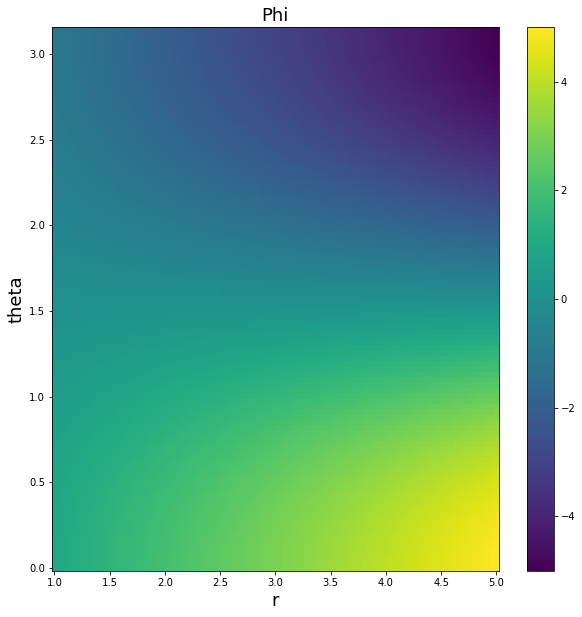

In [289]:
Plot(r, theta, w)

In [290]:
u, v, p = uvp(w)

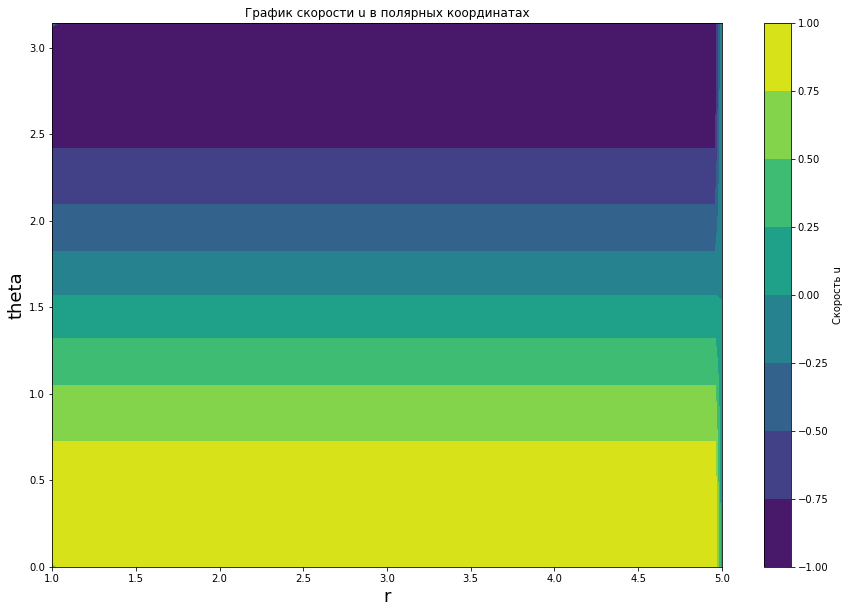

In [291]:
plot_u(u)

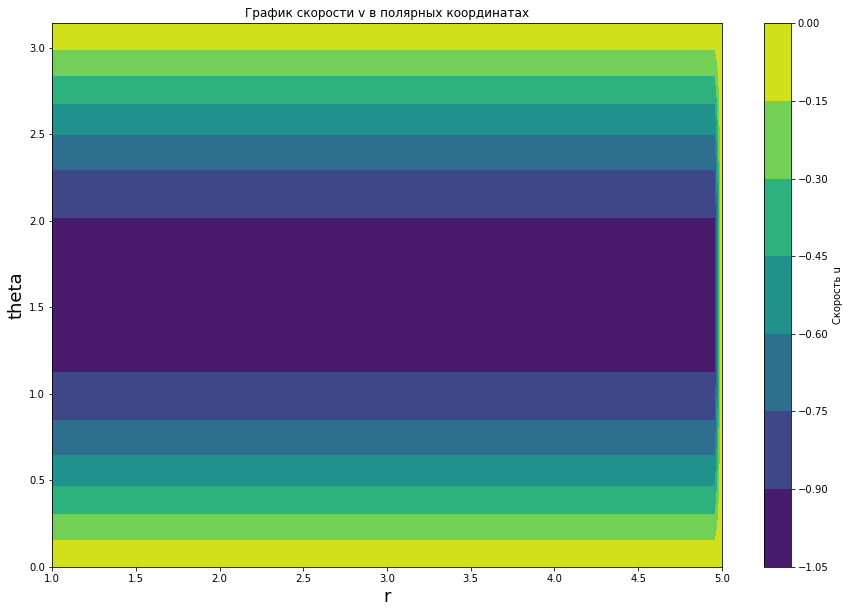

In [292]:
plot_v(v)

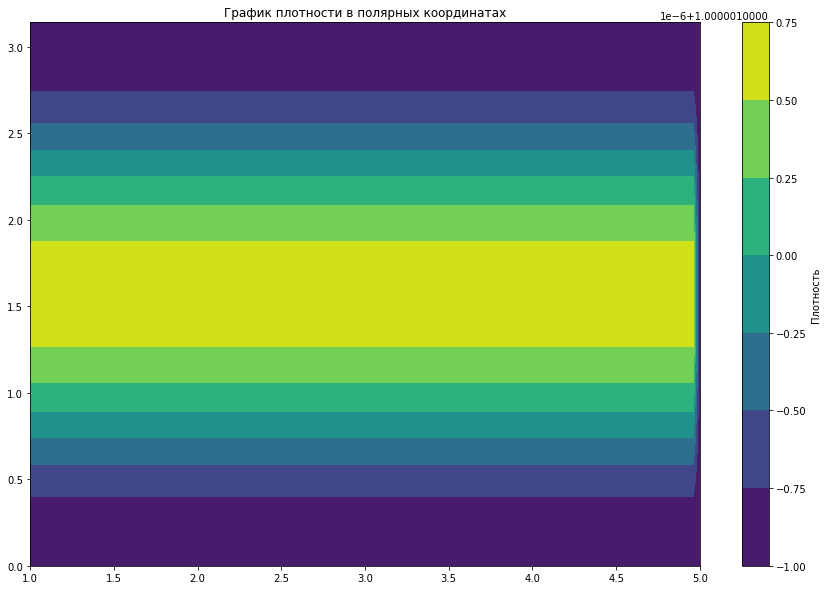

In [293]:
plot_p(p)

In [294]:
iter = 100  # Устанавливаем количество итераций
for itr in tqdm(range(iter)):
    B, D, F, H,sm, osp = coeff(w)
    w = FEM(w, B, D, F, H, sm, osp)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


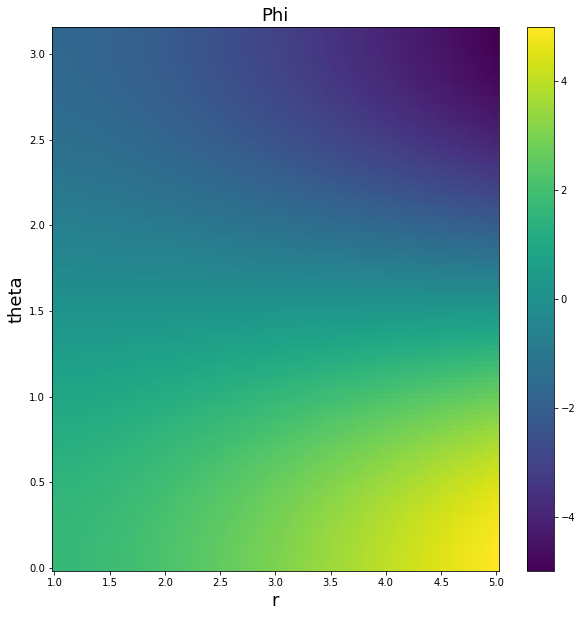

In [295]:
Plot(r, theta, w)

In [296]:
u, v, p = uvp(w)

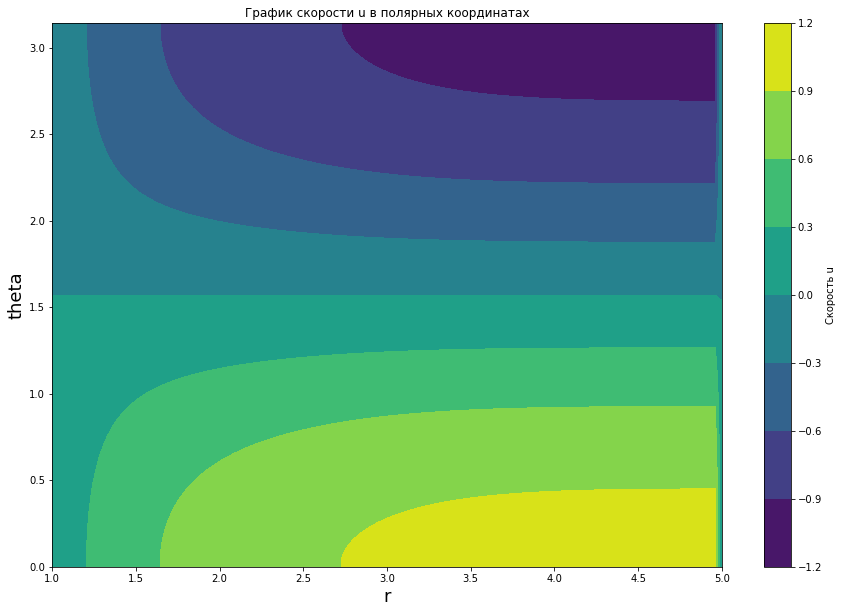

In [297]:
plot_u(u)

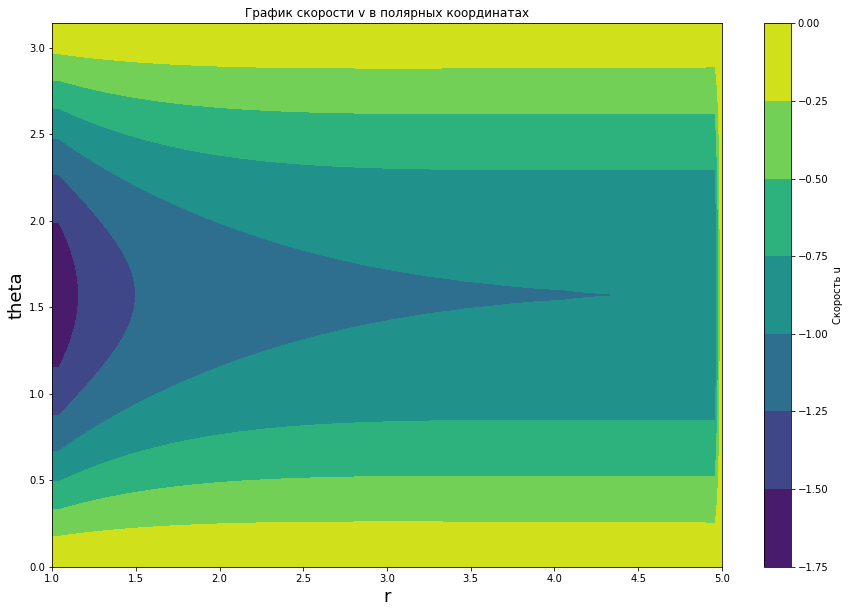

In [298]:
plot_v(v)

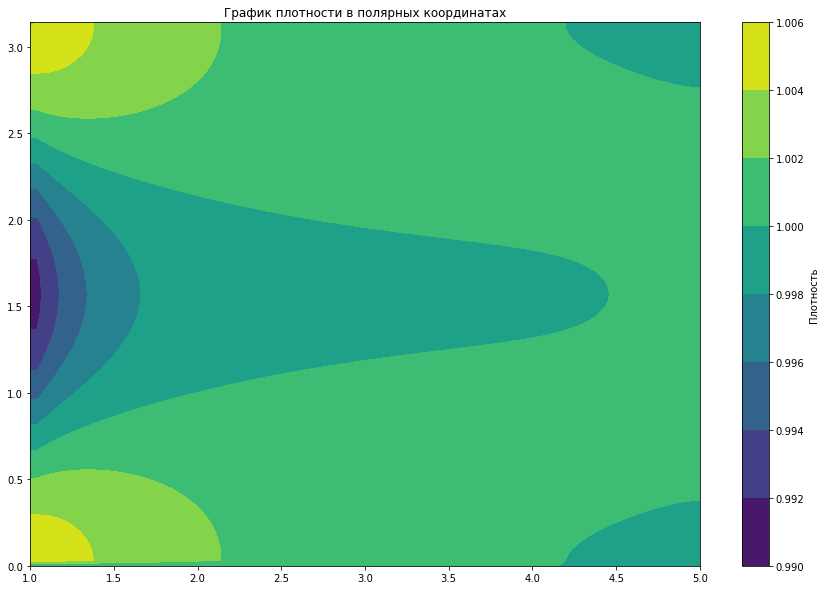

In [299]:
plot_p(p)

In [ ]:
np.save("./Mach_0_45.txt", w)

In [ ]:
a2 = 1.4 * p[0, :] **(1.4 - 1)
M2 = (u[0, :]**2 + v[0, :]**2) / a2
M_0_45 = np.sqrt(M2) * Mah

plt.figure(figsize=(15, 10))
plt.plot(theta, M_0_45, label = "Mach = 0")


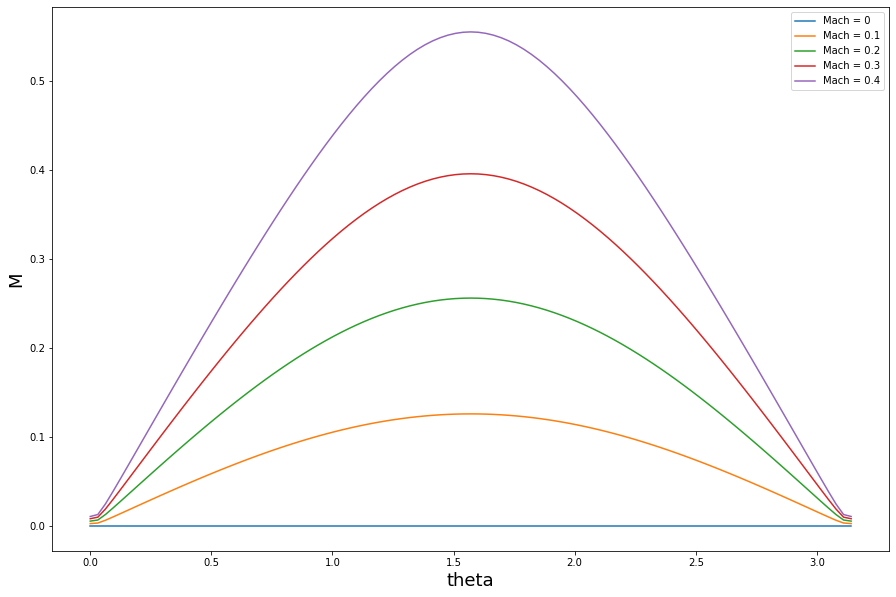

In [386]:
plt.figure(figsize=(15, 10))

plt.plot(theta, M_0, label = "Mach = 0")
plt.plot(theta, M_0_1, label = "Mach = 0.1")
plt.plot(theta, M_0_2, label = "Mach = 0.2")
plt.plot(theta, M_0_3, label = "Mach = 0.3")
plt.plot(theta, M_0_4, label = "Mach = 0.4")
plt.xlabel("theta", fontsize=18)
plt.ylabel("M", fontsize=18)

plt.legend()


In [381]:
def plot_uvp(w):
    u, v, p = uvp(w)
    R, Theta = np.meshgrid(r, theta)
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    c = ax.contourf(R, Theta, u.T, cmap='viridis')
    plt.colorbar(c, label='Скорость u')
    plt.title('График скорости u в полярных координатах')
    ax.set_xlabel('r', fontsize=18)
    ax.set_ylabel('theta', fontsize=18)
    plt.show()

In [458]:
def get_local_Mah(w, M):
    u0, v0, p0 = uvp(w)
    a2 = 1.4 * p[0, :] **(1.4 - 1)
    M2 = (u[0, :]**2 + v[0, :]**2) / a2
    M = np.sqrt(M2) * M
    return M

In [476]:
w0 = np.load("Mach_0.txt.npy")
M0 = get_local_Mah(w0, 0)

In [477]:
w1 = np.load("Mach_0_1.txt.npy")
M1 = get_local_Mah(w1, 0.1)

In [478]:
w2 = np.load("Mach_0_2.txt.npy")
M2 = get_local_Mah(w2, 0.2)

In [479]:
w3 = np.load("Mach_0_3.txt.npy")
M3 = get_local_Mah(w3, 0.3)

In [480]:
w4 = np.load("Mach_0_4.txt.npy")
M4 = get_local_Mah(w4, 0.4)

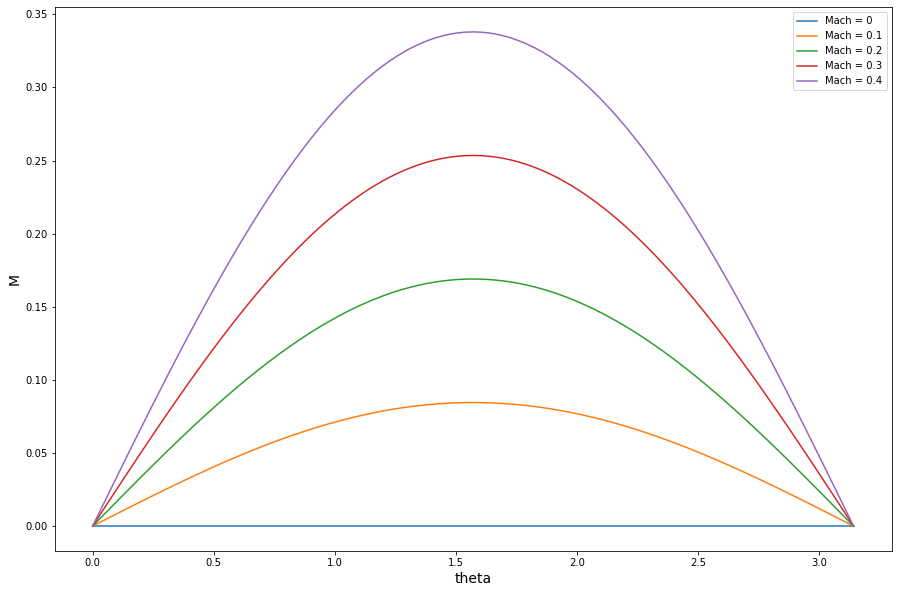

In [481]:
plt.figure(figsize=(15, 10))

plt.plot(theta, M0, label = "Mach = 0")
plt.plot(theta, M1, label = "Mach = 0.1")
plt.plot(theta, M2, label = "Mach = 0.2")
plt.plot(theta, M3, label = "Mach = 0.3")
plt.plot(theta, M4, label = "Mach = 0.4")

plt.xlabel("theta", fontsize=14)
plt.ylabel("M", fontsize=14)

plt.legend()
